In [20]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!pwd

/home/timjab92/code/timjab92/cryptotrading-indicator/notebooks


In [24]:
data = pd.read_csv("../data/BTCUSD_2011-12-31_to_2021-08-23_4hours_Clean.csv")

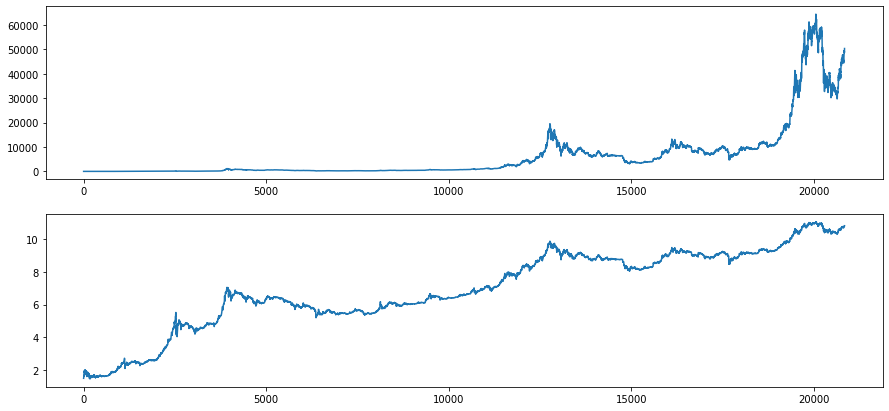

In [25]:
fig, axs = plt.subplots(2,1, figsize=(15,7))
axs[0].plot(data.close)
axs[1].plot(data.log_close)
plt.show()

In [26]:
data = data.drop(columns="Unnamed: 0").set_index("date")

In [27]:
data

,open,high,low,close,volume,log_open,log_high,log_low,log_close
date,,,,,,,,,
2011-12-31 08:00:00,4.390000,4.390000,4.390000,4.390000,0.455581,1.479329,1.479329,1.479329,1.479329
2011-12-31 16:00:00,4.490000,4.513333,4.490000,4.513333,31.620766,1.501702,1.506847,1.501702,1.506847
2012-01-01 04:00:00,4.580000,4.580000,4.580000,4.580000,1.502000,1.521699,1.521699,1.521699,1.521699
2012-01-01 16:00:00,4.840000,4.840000,4.840000,4.840000,10.000000,1.576915,1.576915,1.576915,1.576915
2012-01-01 20:00:00,5.000000,5.000000,5.000000,5.000000,10.100000,1.609438,1.609438,1.609438,1.609438
...,...,...,...,...,...,...,...,...,...
2021-08-22 12:00:00,48769.308417,48787.711375,48749.417500,48769.737750,1.697971,10.794844,10.795222,10.794435,10.794853
2021-08-22 16:00:00,48591.665708,48605.941333,48574.903375,48591.580833,0.463362,10.791204,10.791498,10.790859,10.791202
2021-08-22 20:00:00,48807.713542,48825.874417,48791.558000,48810.168750,0.605696,10.795610,10.795982,10.795279,10.795660


# add ema

In [28]:
data['ema12'] = data.log_close.ewm(span=12).mean()
data['ema26'] = data.log_close.ewm(span=26).mean()
data['ema20'] = data.log_close.ewm(span=20).mean()
data['ema50'] = data.log_close.ewm(span=50).mean()
data['ema34'] = data.log_close.ewm(span=34).mean()
data['ema55'] = data.log_close.ewm(span=55).mean()

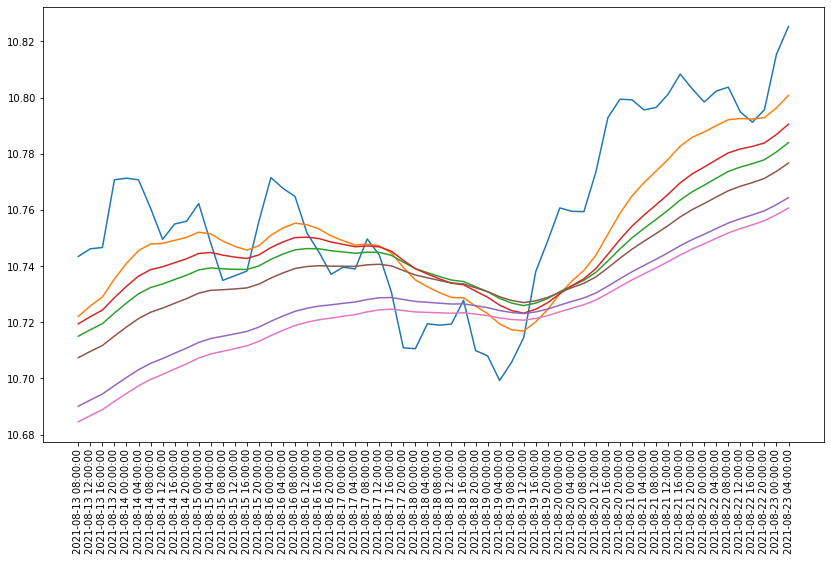

In [30]:
plt.figure(figsize=(14,8))
plt.plot(data[["log_close", "ema12","ema26","ema20","ema50","ema34","ema55"]][-60:])
plt.xticks(rotation=90)
plt.show()

# add stoch rsi

In [31]:
def computeRSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

def stoch_rsi(rsi, d_window, k_window, window):
    minrsi = rsi.rolling(window=window, center=False).min()
    maxrsi = rsi.rolling(window=window, center=False).max()
    stoch = ((rsi - minrsi) / (maxrsi - minrsi)) * 100
    K = stoch.rolling(window=k_window, center=False).mean()
    D = K.rolling(window=d_window, center=False).mean() 
    return K, D  

In [32]:
data['rsi'] = computeRSI(data['log_close'], 14)
data['K'], data['D'] = stoch_rsi(data['rsi'], 3, 3, 14)

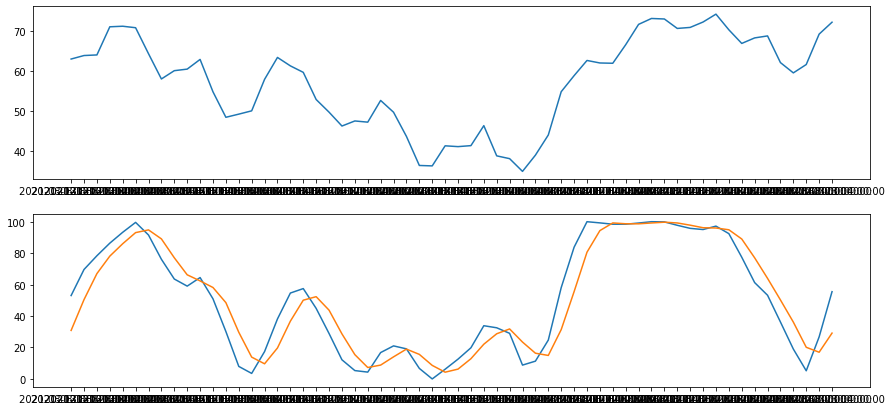

In [33]:
fig, axs = plt.subplots(2,1, figsize=(15,7))
axs[0].plot(data.rsi[-60:])
axs[1].plot(data[["K","D"]][-60:])
plt.show()

# add bollinger bands

In [34]:
def get_sma(prices, rate):
    return prices.rolling(rate).mean()


def get_bollinger_bands(prices, rate=20):
    sma = get_sma(prices, rate) # <-- Get SMA for 20 days
    std = prices.rolling(rate).std() # <-- Get rolling standard deviation for 20 days
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return bollinger_up, bollinger_down

In [35]:
data['sma'] = get_sma(data['log_close'], 20) # Get 20 day SMA
data['bollinger_up'], data['bollinger_down'] = get_bollinger_bands(data['log_close'])

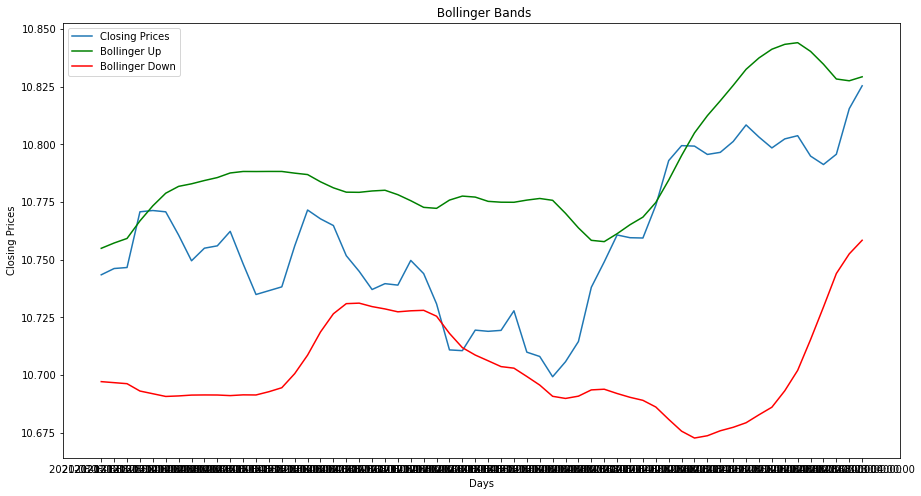

In [36]:
plt.figure(figsize=(15,8))
plt.title(' Bollinger Bands')
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.plot(data['log_close'][-60:], label='Closing Prices')
plt.plot(data['bollinger_up'][-60:], label='Bollinger Up', c='g')
plt.plot(data['bollinger_down'][-60:], label='Bollinger Down', c='r')
plt.legend()
plt.show()

# volume rate of change

In [37]:
data['vol_roc'] = data.volume.pct_change()

# final dataframe

In [39]:
data = data.drop(columns=['open','high','low','close'])

In [40]:
data

,volume,log_open,log_high,log_low,log_close,ema12,ema26,ema20,ema50,ema34,ema55,rsi,K,D,sma,bollinger_up,bollinger_down,vol_roc
date,,,,,,,,,,,,,,,,,,
2011-12-31 08:00:00,0.455581,1.479329,1.479329,1.479329,1.479329,1.479329,1.479329,1.479329,1.479329,1.479329,1.479329,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 16:00:00,31.620766,1.501702,1.506847,1.501702,1.506847,1.494235,1.493617,1.493776,1.493363,1.493493,1.493338,NaN,NaN,NaN,NaN,NaN,NaN,68.407580
2012-01-01 04:00:00,1.502000,1.521699,1.521699,1.521699,1.521699,1.504954,1.503707,1.504029,1.503189,1.503453,1.503138,NaN,NaN,NaN,NaN,NaN,NaN,-0.952500
2012-01-01 16:00:00,10.000000,1.576915,1.576915,1.576915,1.576915,1.527669,1.524173,1.525070,1.522741,1.523470,1.522600,NaN,NaN,NaN,NaN,NaN,NaN,5.657790
2012-01-01 20:00:00,10.100000,1.609438,1.609438,1.609438,1.609438,1.549885,1.543946,1.545478,1.541494,1.542744,1.541253,NaN,NaN,NaN,NaN,NaN,NaN,0.010000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-22 12:00:00,1.697971,10.794844,10.795222,10.794435,10.794853,10.792529,10.775250,10.781677,10.756861,10.768406,10.753323,62.080327,36.210154,50.235845,10.777789,10.840219,10.715358,2.306553
2021-08-22 16:00:00,0.463362,10.791204,10.791498,10.790859,10.791202,10.792325,10.776432,10.782584,10.758207,10.769709,10.754676,59.525060,19.004941,36.146357,10.782060,10.834660,10.729461,-0.727108
2021-08-22 20:00:00,0.605696,10.795610,10.795982,10.795279,10.795660,10.792838,10.777856,10.783830,10.759676,10.771192,10.756140,61.603611,5.196078,20.137058,10.786118,10.828258,10.743977,0.307177
